# Project: What are the underlying patterns and drivers of El Niño events?

### 1 Python libraries

In [28]:
# Loading Python libraries (references provided at the end)
import numpy as np
import pandas as pd
import os
import scipy.optimize as optimize
import scipy.linalg as linalg
import scipy.stats as stats
from scipy import signal, fft
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from pybtex.database import parse_file
import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

### 2 Introduction
El Niño events are among the most significant climate phenomena, with far-reaching impacts on weather patterns, ecosystems, and socioeconomic systems worldwide. Understanding the dynamics of El Niño and its associated oceanic and atmospheric variables is essential for predicting and mitigating its effects. In this project, I explore the the underlying patterns and drivers of El Niño events.

#### 2.1 Data

The El Niño dataset used in this project was obtained from the UCI Machine Learning Repository [1]. It consists of oceanographic and surface meteorological measurements collected from the Tropical Atmosphere Ocean (TAO) array, spanning the period from March 1980 to June 1998. The TAO array was established as part of the international Tropical Ocean Global Atmosphere (TOGA) program, with the objective of studying climate variations originating in the tropics, particularly those associated with the El Niño/Southern Oscillation (ENSO) cycles [2].

The data were obtained from nearly 70 moored buoys strategically deployed across the equatorial Pacific Ocean (shown in the plot below). These buoys were developed and operated by the National Oceanic and Atmospheric Administration's (NOAA) Pacific Marine Environmental Laboratory (PMEL). Each buoy within the TAO array is equipped with sensors to measure a variety of oceanographic and surface meteorological variables crucial for understanding and predicting climate variations.

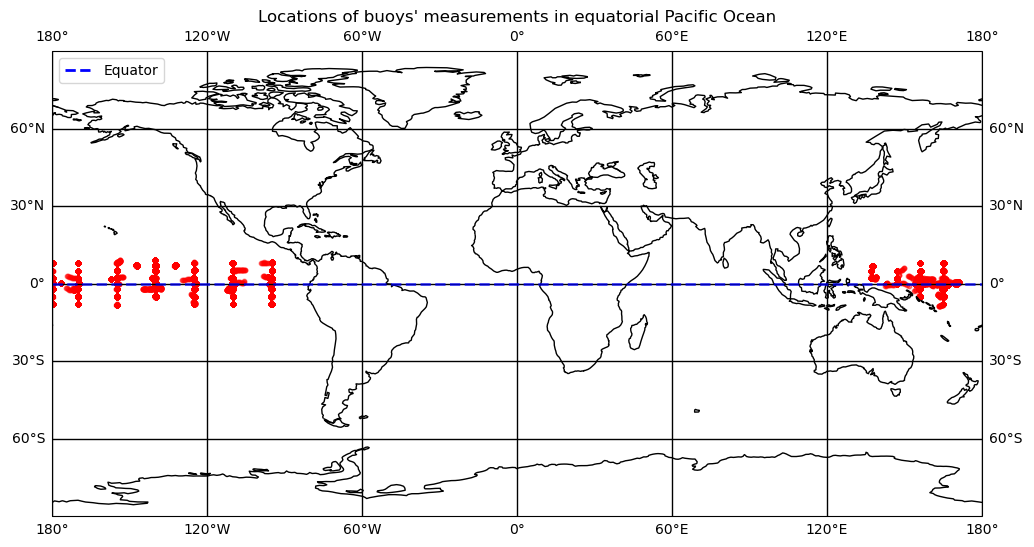

In [3]:
project_path = os.path.abspath("Final Project.ipynb")
elninodata = pd.read_csv(os.path.join(os.path.dirname(project_path), "datasets/elninodatacsv.csv"), na_values='.')

# Create a map
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Set the extent of the map
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # Set extent to cover the entire globe

# Plot latitude and longitude data
ax.scatter(elninodata['Lon'], elninodata['Lat'], color='red', s=10, alpha=0.5)

# Add degree ticks for West, East, North, and South
ax.gridlines(draw_labels=True, linewidth=1, color='black', linestyle='-')

# Add equator line
equator_line = ax.gridlines(ylocs=[0],xlocs=[],  draw_labels=False, linewidth=2, color='blue', linestyle='--', alpha=0.7)

# Create a proxy artist for the legend
equator_legend = Line2D([0], [0], linestyle='--', color='blue', linewidth=2)

# Add legend for equator line
ax.legend([equator_legend], ['Equator'], loc='upper left')

plt.title('Locations of buoys\' measurements in equatorial Pacific Ocean')
plt.show()


#### 2.2 Variables
Each variable has 178,080 entries (including missing NaN values) that represent the data collected from 1980 to 1998. The measured variables include air temperature, relative humidity, surface winds, and sea surface temperatures.  

- *Year, Month, Day, Date*: These variables provide temporal information, specifying the year, month, day, and full date of each observation.


- *Lat (Latitude), Lon (Longitude)*: Latitude and longitude coordinates denote the precise location of the buoy at the time of observation. These coordinates exhibit variability over time, reflecting the movement of buoys within the equatorial Pacific region.


- *ZonWinds (Zonal Winds), MerWinds (Meridional Winds)*: Zonal winds represent the component of wind blowing in the east-west direction, while meridional winds represent the component blowing in the north-south direction.  For zonal winds negative values indicate westward winds, while positive values indicate eastward winds (range: -10 m/s to 10 m/s). For meridional winds, negative values indicate southward winds, while positive values indicate northward winds (range: -10 m/s to 10 m/s). These wind components are crucial for understanding atmospheric circulation patterns.


- *Humidity*: Relative humidity measurements provide insights into the moisture content of the air surrounding the buoy. The humidity ranges from 70% to 90%.


- *AirTemp (Air Temperature), SST (Sea Surface Temperature)*: Air temperature represents the temperature of the air surrounding the buoy, while sea surface temperature reflects the temperature of the ocean surface. SST ranges from 20 to 30 degrees Celsius. These temperature variables play a critical role in determining regional climate patterns and ocean-atmosphere interactions, particularly in the context of ENSO events.

#### 2.3 Research Objectives

**My objectives are:**

- Explore relationships and interactions among variables using techniques like covariance matrices, and principal component analysis.

- Develop predictive models for forecasting El Niño events, employing techniques such linear regression, polynomial regression and lasso.

- Assess the goodness of fit and statistical significance of models using MSE, $R^2$.

- Perform Lomb-Scargle periodogram analysis on El Niño SST data to get insights into the periodic patterns and frequencies

### 3 Data Cleaning, Splitting, Normalization and Exploratory Data Analysis (EDA)

To begin, I load the dataset into a dataframe using Pandas [8].

In [4]:
# Loading data
project_path = os.path.abspath("Final Project.ipynb")
elninodata = pd.read_csv(os.path.join(os.path.dirname(project_path), "datasets/elninodatacsv.csv"), na_values='.')
print(elninodata)

        Observation  Year  Month  Day    Date   Lat     Lon  ZonWinds  \
0                 1    80      3    7  800307 -0.02 -109.46      -6.8   
1                 2    80      3    8  800308 -0.02 -109.46      -4.9   
2                 3    80      3    9  800309 -0.02 -109.46      -4.5   
3                 4    80      3   10  800310 -0.02 -109.46      -3.8   
4                 5    80      3   11  800311 -0.02 -109.46      -4.2   
...             ...   ...    ...  ...     ...   ...     ...       ...   
178075       178076    98      6   11  980611  8.96 -140.33      -5.1   
178076       178077    98      6   12  980612  8.96 -140.32      -4.3   
178077       178078    98      6   13  980613  8.95 -140.34      -6.1   
178078       178079    98      6   14  980614  8.96 -140.33      -4.9   
178079       178080    98      6   15  980615  8.95 -140.33       NaN   

        MerWinds  Humidity  AirTemp    SST  
0            0.7       NaN    26.14  26.24  
1            1.1       NaN    25.

In [5]:
# Check if there are any remaining missing values
missing_values = elninodata.isnull().sum()
print("Remaining missing values:")
print(missing_values)

Remaining missing values:
Observation        0
Year               0
Month              0
Day                0
Date               0
Lat                0
Lon                0
ZonWinds       25163
MerWinds       25162
Humidity       65761
AirTemp        18237
SST            17007
dtype: int64


#### 3.1 Handling missing values

As it can be seen fron the output above, there are a lot of missing data in this dataset. Before proceeding to the data analysis, it is important to deal with this issue. There are several ways to about this problem. First, Forward Fill (ffill) or Backward Fill (bfill), where the value from the previous (forward fill) or next (backward fill) observation can be used to fill in missing values. This method is useful for time series data where values are often correlated across adjacent time points. Second, interpolation, where estimation of missing values is based on the values of neighboring data points. This can be linear interpolation, polynomial interpolation, or spline interpolation, depending on the data's characteristics and underlying patterns. There are also imputation methods, like mean or median imputation, but they can introduce bias into the dataset by altering the distribution of the variables.

I think it is possible to use interpolation here. SST and Air Temperature values are often correlated with neighboring locations and tend to vary smoothly over space and time, so interpolation can be suitable assuming the temperature changes gradually. Wind patterns can be influenced by various factors including geographical features and atmospheric conditions, so interpolation may be more appropriate for filling missing wind data, especially since the missing values occur in regions with significant variability in wind patterns. Humidity values exhibit more variability, fluctuate rapidly and may not change smoothly over time compared to temperature, so interpolation method might also be suitable.

In [6]:
# Interpolate missing values for 'SST'
elninodata['SST'] = elninodata['SST'].interpolate(method='linear')

# Interpolate missing values for 'Humidity'
elninodata['Humidity'] = elninodata['Humidity'].interpolate(method='linear')

# Interpolate missing values for 'ZonWinds'
elninodata['ZonWinds'] = elninodata['ZonWinds'].interpolate(method='linear')

# Interpolate missing values for 'MerWinds'
elninodata['MerWinds'] = elninodata['MerWinds'].interpolate(method='linear')

# Interpolate missing values for 'AirTemp'
elninodata['AirTemp'] = elninodata['AirTemp'].interpolate(method='linear')

# Check if there are any remaining missing values
missing_values = elninodata.isnull().sum()
#print("Remaining missing values:")
#print(missing_values)

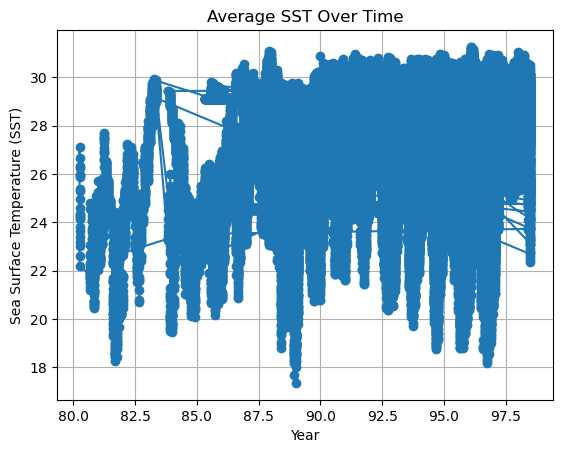

In [7]:
# Plotting SST over time
plt.plot(elninodata['Year'] + elninodata['Month'] / 12, elninodata['SST'], marker='o')
plt.xlabel('Year')
plt.ylabel('Sea Surface Temperature (SST)')
plt.title('Average SST Over Time')
plt.grid(True)
plt.show()


Our data above is daily. However, montly averages can help smooth out short-term fluctuations or noise present in the data. This can make it easier to identify underlying trends or patterns, especially when dealing with noisy or irregularly sampled data. Furthermore, phenomenon like El Nino exhibits seasonal patterns or cycles. Averaging data over monthly intervals allows for the examination of these seasonal variations.

In [8]:
# Select columns to include in averaging
columns_to_average = ['Year', 'Month', 'Lat', 'Lon', 'ZonWinds', 'MerWinds', 'Humidity', 'AirTemp', 'SST']

# Group by 'Year' and 'Month' and calculate the mean of each variable
elninodata_month_avg = elninodata[columns_to_average].groupby(['Year', 'Month']).mean()

# Reset index to convert the grouped data back to a DataFrame
elninodata_month_avg = elninodata_month_avg.reset_index()

# Display the resulting DataFrame
print(elninodata_month_avg)

     Year  Month       Lat         Lon  ZonWinds  MerWinds   Humidity  \
0      80      3 -0.020000 -109.460000 -3.417391  0.882609        NaN   
1      80      8  0.000000 -109.560000 -4.319048  2.514286        NaN   
2      80      9  0.000000 -109.560000 -4.170000  3.263333        NaN   
3      80     10  0.000000 -109.560000 -3.954839  2.174194        NaN   
4      80     11  0.000000 -109.560000 -4.923333  4.150000        NaN   
..    ...    ...       ...         ...       ...       ...        ...   
206    98      2  0.378434  -65.579104 -2.163652 -3.028102  81.607148   
207    98      3  0.418548  -67.244464 -2.000601 -2.941944  81.753971   
208    98      4  0.347618  -70.286544 -2.432405 -2.316608  82.371690   
209    98      5  0.301005  -69.083897 -3.810367 -0.958292  83.705811   
210    98      6  0.250348  -68.125537 -3.929314 -0.459683  83.852427   

       AirTemp        SST  
0    25.793478  24.670870  
1    21.878095  22.201429  
2    22.167000  22.551333  
3    21.278

Plot averaged variables.

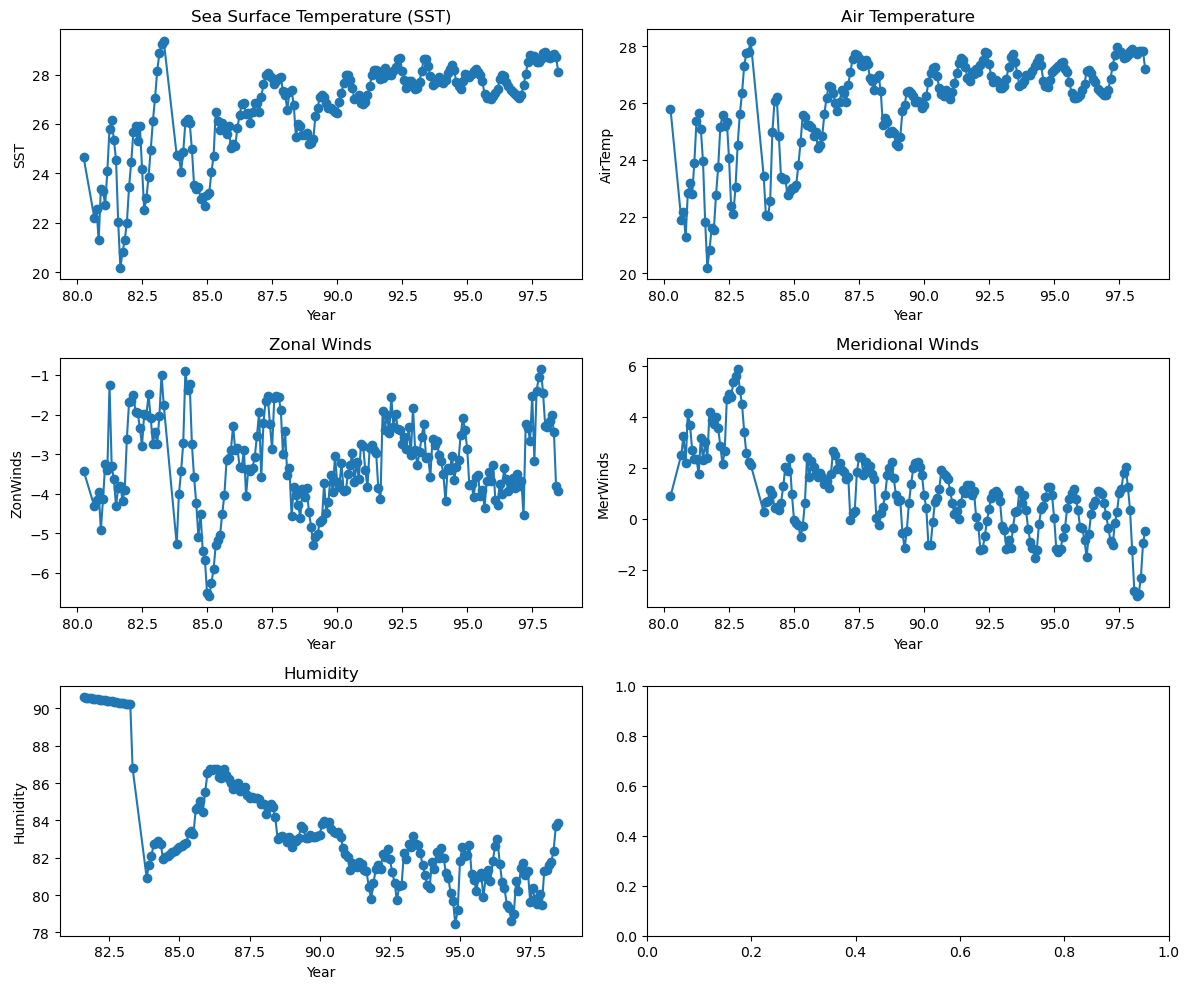

In [9]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Plot SST
axs[0, 0].plot(elninodata_month_avg['Year'] + elninodata_month_avg['Month'] / 12, elninodata_month_avg['SST'], marker='o', linestyle='-')
axs[0, 0].set_title('Sea Surface Temperature (SST)')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('SST')

# Plot AirTemp
axs[0, 1].plot(elninodata_month_avg['Year'] + elninodata_month_avg['Month'] / 12, elninodata_month_avg['AirTemp'], marker='o', linestyle='-')
axs[0, 1].set_title('Air Temperature')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('AirTemp')

# Plot ZonWinds
axs[1, 0].plot(elninodata_month_avg['Year'] + elninodata_month_avg['Month'] / 12, elninodata_month_avg['ZonWinds'], marker='o', linestyle='-')
axs[1, 0].set_title('Zonal Winds')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('ZonWinds')

# Plot MerWinds
axs[1, 1].plot(elninodata_month_avg['Year'] + elninodata_month_avg['Month'] / 12, elninodata_month_avg['MerWinds'], marker='o', linestyle='-')
axs[1, 1].set_title('Meridional Winds')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('MerWinds')

# Plot Humidity
axs[2, 0].plot(elninodata_month_avg['Year'] + elninodata_month_avg['Month'] / 12, elninodata_month_avg['Humidity'], marker='o', linestyle='-')
axs[2, 0].set_title('Humidity')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Humidity')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


From the SST plot above we can see two strongest above-average sea surface temperatures (SST) in the central and eastern tropical Pacific Ocean. This indicates strongest El Nino events that took place in 1982/1983 and 1997/1998 [5].

#### 3.2 Normalization

Normalization is a data preprocessing technique used to scale the features of a dataset to a similar range, typically between 0 and 1 or with a mean of 0 and standard deviation of 1. Normalization is particularly useful when dealing with numerical features that have different scales, as it ensures that all features contribute equally to the analysis, prevents features with larger scales from dominating the others, and can improve the performance of certain machine learning algorithms.

However, in my dataset, it seems that the data is already standardized or normalized since some numerical features (such as $Lat$, $Lon$, $ZonWinds$, $MerWinds$, $AirTemp$, and $SST$) are already appear to have been scaled or standardized, as their values fall within specific ranges. So normalization might not be necessary for all features.

It's also worth noting that dates, latitude and longitue do not need to be normalized since they represent categories or ordinal values rather than continuous numerical values. 

#### 3.3 Covariance matrix

Covariance matrix is a valuable tool in Exploratory Data Analysis (EDA). Covariance measures the degree to which two variables vary together. Important to notice that covariances provide insights into the relationships between variables but do not imply causation. 

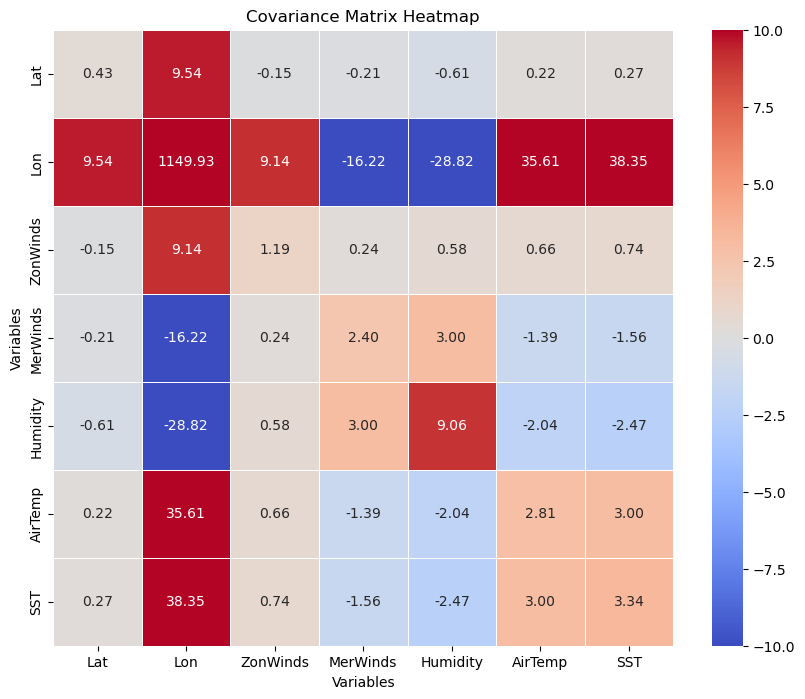

In [10]:
# Drop the 'Year',  'Month'
elninodata_respvar = elninodata_month_avg.drop(columns=['Year', 'Month'])

#Compute the covariance matrix
cov_matrix = elninodata_respvar.cov()

# Print the covariance matrix
#print("Covariance Matrix:\n", cov_matrix)

# Plot the covariance matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-10, vmax=10)
plt.title("Covariance Matrix Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

Above we can see a covariance heatmap for the variables. 

The diagonal elements of the matrix represent the variances of individual variables. For example, the variance of $Humidity$ is approximately 9.06, $SST$ is approximately 3.34, and so on. 

The off-diagonal elements represent the covariance between pairs of variables. A positive covariance indicates a positive relationship, while a negative covariance indicates a negative relationship. Larger covariance values suggest stronger relationships, while smaller values suggest weaker relationships. For example, covariance between $SST$ and $AirTemp$ is positive (3.0), indicating that they tend to increase or decrease together. Covariance between $AirTemp$ and $Humidity$ is negative (-2.028423), indicating an inverse relationship between humidity and air temperature. This makes sense because warmer air has the capacity to hold a greater amount of water vapor compared to colder air. Consequently, given equal absolute or specific humidity levels, air will exhibit a higher relative humidity when cooler and a lower relative humidity when warmer [3].


It is also noticable that $Lon$ has a covariance of 9.14 with $ZonWinds$. This relatively high covariance suggests a stronger association between longitude and zonal winds, indicating that Zonal Winds may vary considerably with changes in longitude. $Lon$ has a covariance of 38.35 with $SST$, meaning longitude shows a relatively strong association with SST.

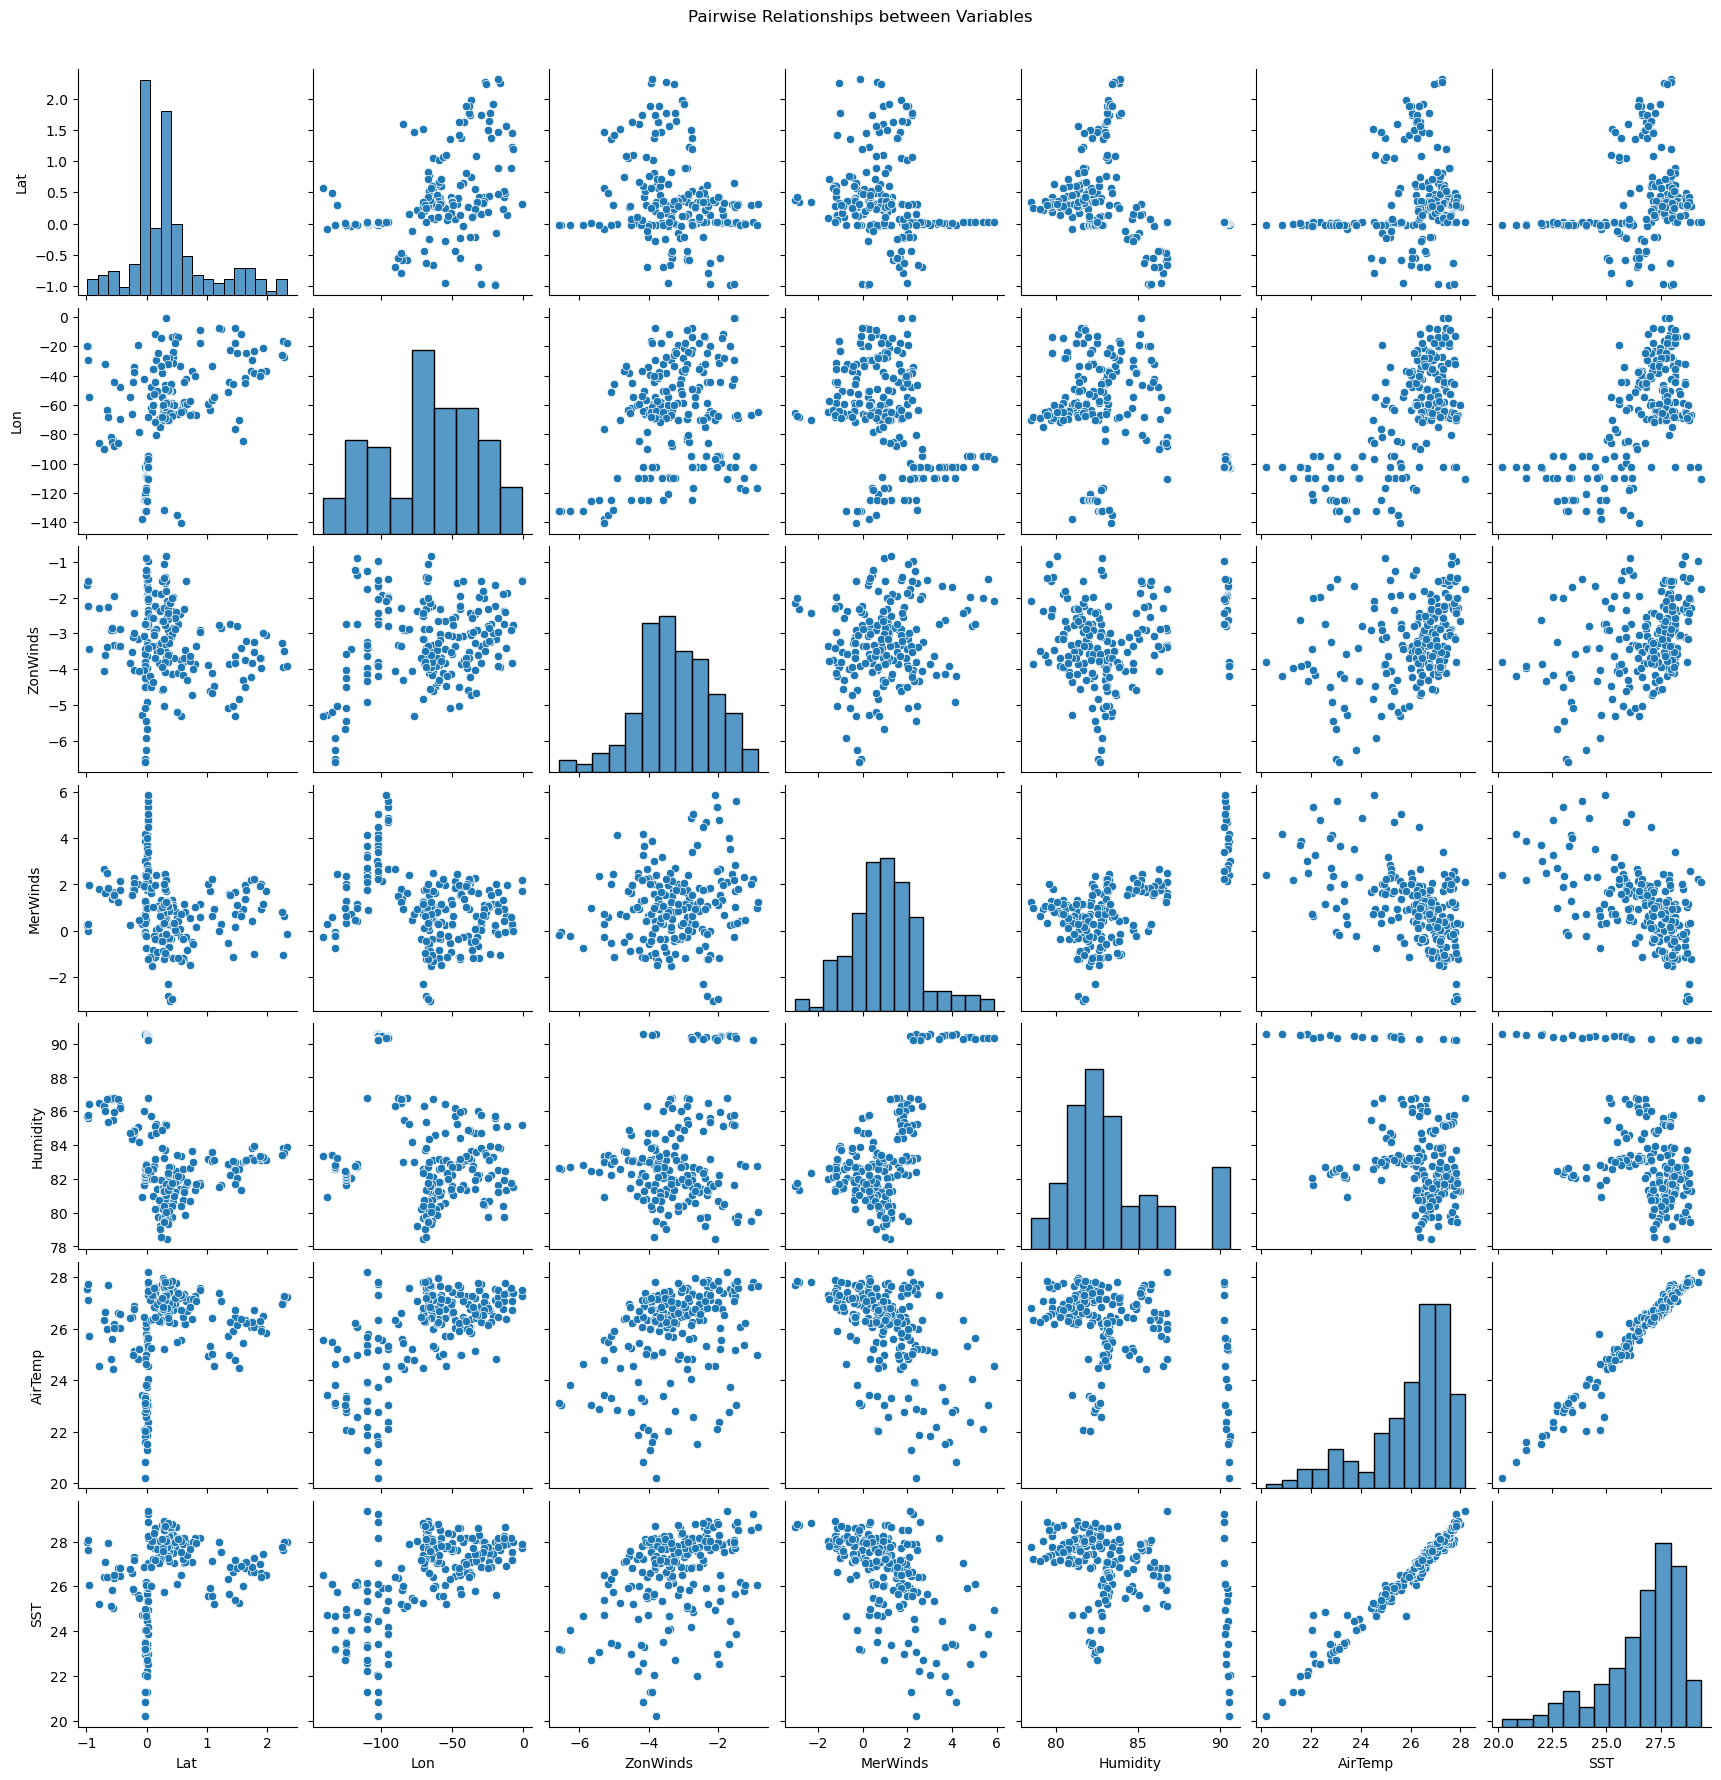

In [11]:
# Creating scatterplot matrix to find pairwise relationships between variables 

# Dropping the 'Year',  'Month', 'Lat', 'Lon' columns
elninodata_respvar = elninodata_month_avg.drop(columns=['Year', 'Month'])
sns.pairplot(elninodata_respvar)
plt.suptitle("Pairwise Relationships between Variables", y=1.02)
plt.show()

Above, as a part of EDA, a scatterplot matrix displaying pairwise relationships between variables was generated. Each scatterplot shows the relationship between two variables, with the variable on the x-axis plotted against the variable on the y-axis. The diagonal of the matrix displays histograms for each variable.

Most of the scatterplots (except for those between $AirTemp$ and $SST$, $AirTemp$ and $MerWinds$, $SST$ and $MerWinds$) appear as a circular cloud of data points with no discernible pattern, and it may indicate weak or non-existent linear relationships between the variables.

#### 3.4 Correlation analysis

Now, it is important to explore potential collinearity between variables to ensure the reliability of regression models and to identify redundant predictors. Collinearity occurs when two or more variables in a regression model are highly correlated with each other, which can lead to unstable estimates of the coefficients and reduced interpretability of the model. I calculate the correlation matrix, where high absolute correlation coefficients (close to 1 or -1) indicate strong collinearity.

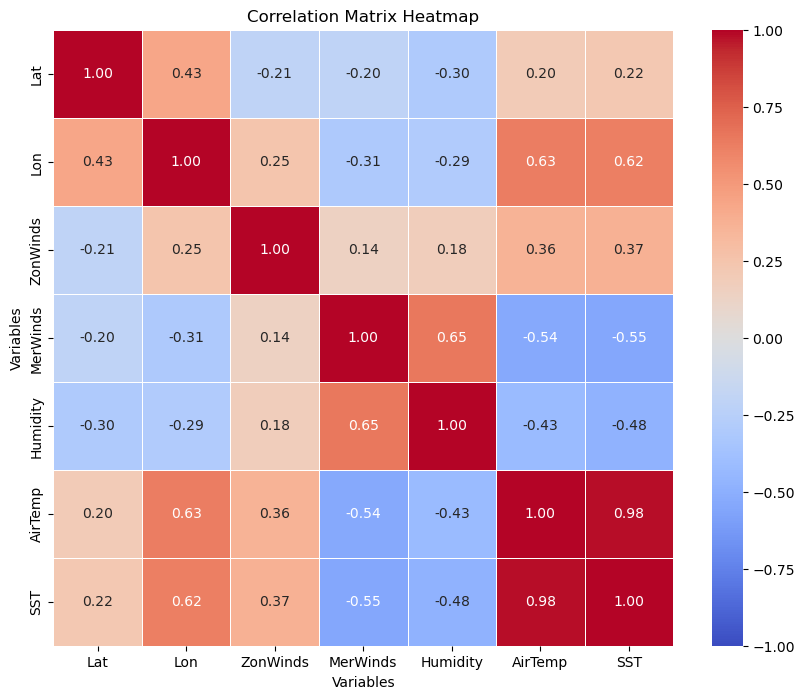

In [12]:
# Drop the 'Date', 'Observation',  'Year',  'Month',  'Day' columns since
elninodata_respvar = elninodata_month_avg.drop(columns=['Year', 'Month'])

# Compute the correlation matrix
corr_matrix = elninodata_respvar.corr() 

# Display the correlation matrix
#print("Correlation Matrix:")
#print(corr_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")
plt.show()

Interpretation of the correlation matrix: 
$ZonWinds$ and $SST$ have a moderately positive correlation of 0.37, indicating that zonal winds tend to be associated with higher sea surface temperatures. $AirTemp$ and $SST$ have a very strong positive correlation of 0.98, suggesting a nearly perfect positive linear relationship between air temperature and sea surface temperature.
$MerWinds$ and $AirTemp$ have a moderate negative correlation of -0.54, indicating that meridional winds tend to be associated with lower air temperatures. $Lon$ and $SST$ have a correlation coefficient of approximately 0.62, indicating that as longitude increases (moves eastward), there tends to be a corresponding increase in sea surface temperature. Conversely, as longitude decreases (moves westward), there tends to be a decrease in sea surface temperature. However, it's important to note that correlation does not imply causation, and other factors may influence this relationship.


#### 3.5 Principal Component Analysis (PCA)
Setting sea surface temperature ($SST$) as the response variable and zonal winds ($ZonWinds$), meridional winds ($MerWinds$), $Humidity$, and air temperature ($AirTemp$) as the explanatory variables is a reasonable choice. This  aligns with the known dynamics of El Niño events, where changes in atmospheric conditions, such as wind patterns and humidity, can influence sea surface temperatures in the central and eastern Pacific Ocean. According to the NASA, during an El Niño event, the surface waters in the central and eastern Pacific Ocean become significantly warmer than usual due to the atmosphere and to the winds blowing over the vast Pacific [4].

PCA is performed to identify the variables that contribute the most to the variability in the dataset. By examining the loadings of the original variables on the principal components, it is possible to find which variables are most significant in explaining the patterns in the data. Moreover, from above we saw that some variables are highly correlated with each other, so PCA resolves multicollinearity by creating orthogonal principal components that are uncorrelated with each other. 

In [13]:
# Remove rows with NaN values in the 'Humidity' column
elninodata_cleaned = elninodata_month_avg.dropna(subset=['Humidity'])

# Check if NaN values are removed
#print(elninodata_cleaned.isnull().sum())

# Select explanatory variables
X = elninodata_cleaned[['ZonWinds', 'MerWinds', 'Humidity', 'AirTemp', 'Lat', 'Lon']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

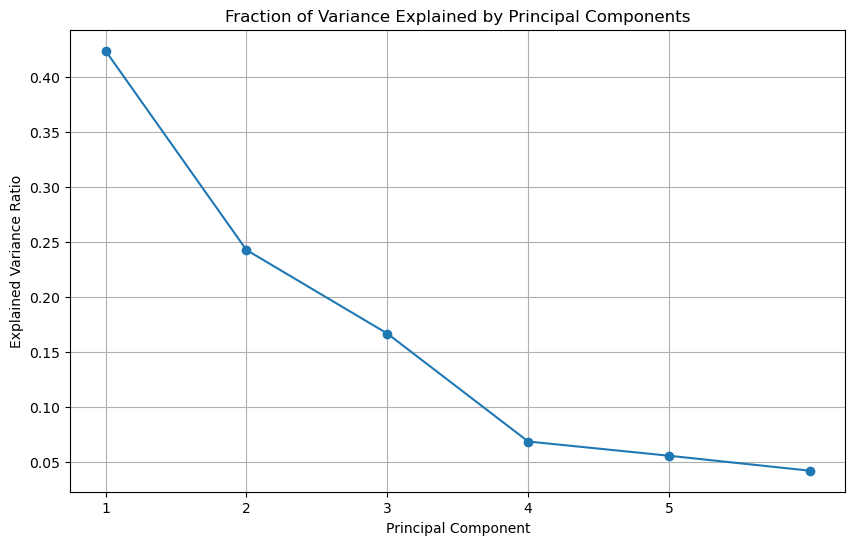

Number of principal components capturing more than 5% of total variance each: 5


In [14]:
# Calculate covariance matrix
cov_matrix = np.cov(X_scaled, rowvar=False)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Calculate fraction of variance explained by each principal component
explained_variance_ratio = sorted_eigenvalues / np.sum(sorted_eigenvalues)

# Plot the fraction of variance explained by the largest 20 eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Fraction of Variance Explained by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

# Count the number of principal components that capture more than 5% of the total variance each
components_exceeding_5_percent = sum(explained_variance_ratio > 0.05)
print("Number of principal components capturing more than 5% of total variance each:", components_exceeding_5_percent)

In [15]:
pca = PCA()
pca.fit(X)

# Get the principal component loadings
loadings = pd.DataFrame(pca.components_, columns=X.columns)

# Get the absolute values of loadings for each principal component
abs_loadings = loadings.abs()

# Identify the variables with the highest loadings for each principal component
significant_variables = []
for i in range(len(abs_loadings)):
    component_loadings = abs_loadings.iloc[i]
    significant_vars = component_loadings.sort_values(ascending=False)[:5].index.tolist()
    significant_variables.append(significant_vars)

# Print the significant variables for each principal component
for i, vars in enumerate(significant_variables):
    print(f"Principal Component {i+1}: {', '.join(vars)}")


Principal Component 1: Lon, AirTemp, Humidity, MerWinds, Lat
Principal Component 2: Humidity, MerWinds, AirTemp, ZonWinds, Lat
Principal Component 3: AirTemp, ZonWinds, MerWinds, Humidity, Lat
Principal Component 4: MerWinds, ZonWinds, Humidity, Lat, AirTemp
Principal Component 5: AirTemp, ZonWinds, MerWinds, Lat, Humidity
Principal Component 6: Lat, ZonWinds, MerWinds, AirTemp, Humidity


The number of principal components capturing more than 5% of the total variance is 5, so it indicates that 5 out of 6 principal components are contributing significantly to the overall variance in the dataset.

Principal Component 1 (PC1) is a combination of the variables that explains the most variability in the dataset. In this case, Lon, AirTemp, Humidity, MerWinds, and Lat are the primary contributors to PC1. This means that changes in these variables are correlated and likely contribute to similar patterns or trends in the data.

### 4 Analysis and Methodology

To develop predictive models for forecasting El Niño events, linear regression will be used. I will test using all 6 variables to predict $SST$  and 5 variables from PC1 as it was concluded from EDA that 5 variables are the most relevant features (predictors) that may influence SST. To begin, I divide the dataset into training and testing sets to evaluate the model's performance on unseen data. Then, training of the selected models using the training data is performed and cross-validation techniques are used to assess model performance. Finally, the trained models are evaluated using the testing dataset by calculating relevant evaluation metrics such as mean squared error (MSE), mean absolute error (MAE), coefficient of determination (R^2).

#### 4.1 Splitting the data
Sorting the data by date and then splitting it into training and test sets based on a predefined split point (e.g., 80% for training). The training data contains earlier time periods, while the test data contains later time periods.

In [16]:
# Convert 'Year' and 'Month' to datetime format
elninodata_cleaned['Date'] = pd.to_datetime(elninodata_cleaned['Year'].astype(str) + '-' + elninodata_cleaned['Month'].astype(str), format='%y-%m')

# Extracting only Year and Month from the Date
elninodata_cleaned['Year_Month'] = elninodata_cleaned['Date'].dt.to_period('M')

In [17]:
# Sort the data by date
elninodata_cleaned.sort_values(by=['Year', 'Month'], inplace=True)

# Define the split point (e.g., 80% of the data for training)
split_point = int(0.8 * len(elninodata_cleaned))

# Split the data into training and test sets
train_data = elninodata_cleaned.iloc[:split_point]
test_data = elninodata_cleaned.iloc[split_point:]

print("Training set size:", len(train_data))
print("Test set size:", len(test_data))

Training set size: 159
Test set size: 40


#### 4.2 Fitting simple linear regression

Now let's proceed with fitting a simple linear regression model to the training data and evaluating its performance on the test data. 

In [18]:
# Extracting predictors and target variable for training and test sets (exclude 'ZonWinds')
X_train = train_data[['MerWinds', 'Humidity', 'AirTemp', 'Lat', 'Lon']]
y_train = train_data['SST']
time_train = train_data['Date']

X_test = test_data[['MerWinds','Humidity', 'AirTemp','Lat', 'Lon']]
y_test = test_data['SST']
time_test = test_data['Date']

# Fitting a linear regression model to the training data
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

The linear regression model can be expressed as an equation in the form: 
$$SST= \beta_0 + \beta_1 \times MerWinds + \beta_2 \times Humidity + \beta_3 \times AirTemp +  \beta_4 \times Lat +\beta_5 \times Lon$$

Where:$\beta_0$ is intercept and $\beta_1, \beta_2, \beta_3, \beta_4, \beta_5$ are the coefficients for the predictors (ZonWinds, MerWinds, Humidity, AirTemp, Lat and Lon).


Now, finding 95% confidence intervals for the estimated coefficients.
The t-distribution is used because it accounts for the variability in the estimates of the regression coefficients due to the limited sample size. Sincw the distribution of the estimates is not normal, and the t-distribution provides a better approximation.

In [19]:
# Function to compute confidence intervals
def compute_confidence_intervals(X, y, model):
    # Get the predictions
    predictions = model.predict(X)
    
    # Compute residuals
    residuals = y - predictions
    
    # Degrees of freedom
    n = len(y)
    p = X.shape[1]
    dof = n - p - 1
    
    # Compute standard deviation of residuals
    std_error = np.sqrt(np.sum(residuals**2) / dof)
    
    # Compute t-value for 95% confidence interval
    t_value = 1.96
    
    # Compute standard errors for coefficients
    se = np.sqrt(np.diagonal(np.linalg.inv(np.dot(X.T, X)) * std_error**2))
    
    # Compute confidence intervals
    lower_bound = model.coef_ - t_value * se
    upper_bound = model.coef_ + t_value * se
    
    return lower_bound, upper_bound

# Compute confidence intervals for coefficients
lower_bound, upper_bound = compute_confidence_intervals(X_train, y_train, regression_model)

# Print coefficients and confidence intervals
for i, coef in enumerate(regression_model.coef_):
    print(f"𝛽_{i}: {coef:.4f} (95% CI: {lower_bound[i]:.6f}, {upper_bound[i]:.6f})")


𝛽_0: 0.0252 (95% CI: -0.028612, 0.079028)
𝛽_1: -0.0465 (95% CI: -0.061298, -0.031669)
𝛽_2: 1.0220 (95% CI: 0.978715, 1.065335)
𝛽_3: 0.0300 (95% CI: -0.056312, 0.116271)
𝛽_4: -0.0003 (95% CI: -0.002471, 0.001870)


Finally, using the trained model, it is possible to evaluate it using the test set.

In [20]:
# Making predictions on the test data
y_pred = regression_model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error: 0.018156926889513408
Mean Absolute Error: 0.10030524618835593
R-squared Score: 0.956525665713233


Now, plot the predicted and measured SST.

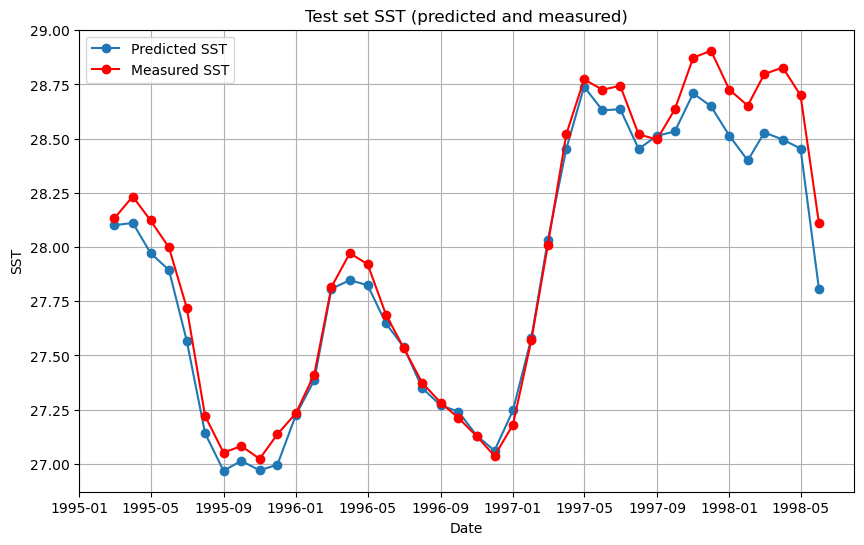

In [21]:
# Plot SST with increasing time
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], y_pred, marker='o', linestyle='-', label='Predicted SST')
plt.plot(test_data['Date'], y_test, 'r', marker='o', linestyle='-', label='Measured SST')
plt.title('Test set SST (predicted and measured)')
plt.xlabel('Date')
plt.ylabel('SST')
plt.grid(True)
plt.legend()
plt.show()

The linear models with 5 and 6 predictors showed slight difference in model performance. Model without Zonal Winds has lower MSE, MAE and R-squared. The MSE and MAE represent the average squared and absolute differences, respectively, between the predicted and actual sea surface temperature (SST) values. A lower MSE and MAE indicate better model performance. The R-squared score measures the proportion of variance in the SST that is explained by the model. It ranges from 0 to 1, where a score closer to 1 indicates a better fit of the model to the data. In our case, the R-squared score of approximately 0.956 suggests that the model explains around 95.6% of the variance in the SST. 

Overall, these results indicate that the linear regression model performs reasonably well in predicting the SST based on the given explanatory variables (Meridional Winds, Humidity, Latitude, Longitude, and Air Temperature). However, we can also look at residuals plot to identify patterns or trends that the model fails to capture.

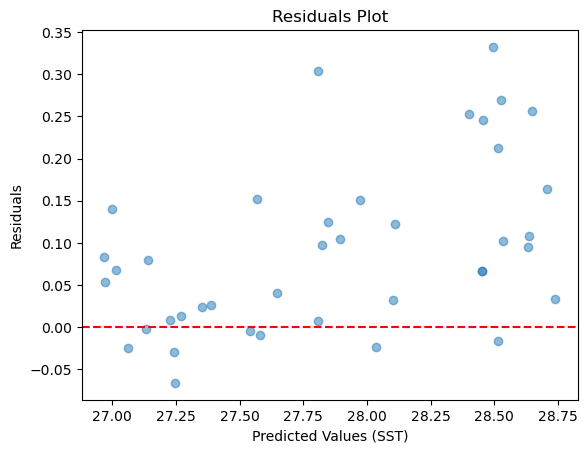

In [22]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values (SST)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

It is possible to observe that there are more positive residuals than negative residuals, it suggests that the model tends to underestimate the target variable (SST) for most of the observations. This might be explained - since the relationship between predictors (except AirTemp) and SST is nonlinear, a linear regression model may not capture it accurately. So, it makes sense to try using more flexible models that can capture nonlinear relationships, such as polynomial regression.

#### 4.3 Finding a more complex regression model

The use of polynomial regression can be justified for several reasons. First, polynomial regression allows for capturing non-linear relationships between predictors and the target variable (SST). Moreover, polynomial regression can model interactions between features by including polynomial terms of the original predictors. For example, humidity, wind speed, and air temperature interact with each other in influencing SST.

In [23]:
# Define the degree of the polynomial
degree = 2 

# Create polynomial features
poly_features = PolynomialFeatures(degree=degree)
X_poly_train = poly_features.fit_transform(X_train)

# Create and fit the polynomial regression model
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)

# Make predictions on the training data
y_train_predicted = poly_model.predict(X_poly_train)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_predicted)
r2_train = r2_score(y_train, y_train_predicted)

print("Train Mean Squared Error:", mse_train)
print("Train R-squared Score:", r2_train)


Train Mean Squared Error: 0.08029152441093558
Train R-squared Score: 0.9741826359543622


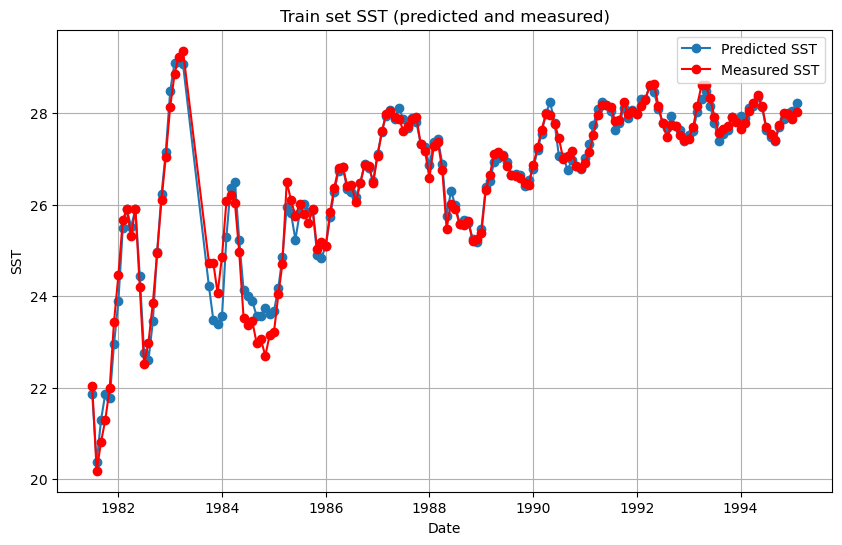

In [24]:
# Plot SST with increasing time
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], y_train_predicted, marker='o', linestyle='-', label='Predicted SST')
plt.plot(train_data['Date'], y_train, 'r', marker='o', linestyle='-', label='Measured SST')
plt.title('Train set SST (predicted and measured)')
plt.xlabel('Date')
plt.ylabel('SST')
plt.grid(True)
plt.legend()
plt.show()

The mean squared error (MSE) of approximately 0.080 and the R-squared score of approximately 0.974 indicate that the polynomial regression model performs quite well on the training data. 

In this case, the relatively low MSE and high R-squared score suggest that the polynomial regression model captures a significant portion of the variance in the target variable and provides accurate predictions on the training data.

In [25]:
# Transform the test features using the same polynomial features
X_poly_test = poly_features.transform(X_test)

# Make predictions on the test data
y_test_predicted = poly_model.predict(X_poly_test)

# Evaluate the model on the test data
mse_test = mean_squared_error(y_test, y_test_predicted)
r2_test = r2_score(y_test, y_test_predicted)

# Print the evaluation metrics
print("Test Mean Squared Error:", mse_test)
print("Test R-squared Score:", r2_test)

Test Mean Squared Error: 0.03856638774948913
Test R-squared Score: 0.9076579399445223


The MSE of 0.039 suggests that, on average, the predictions made by the polynomial regression model are quite close to the actual SST values in the test set. The R-squared score of 0.9 suggests that the polynomial regression model works well to capture the variation in SST, but still performs worse than a simplistic mean-based model. Hence, polynomial regression is not a good choice for predicting SST in our case.

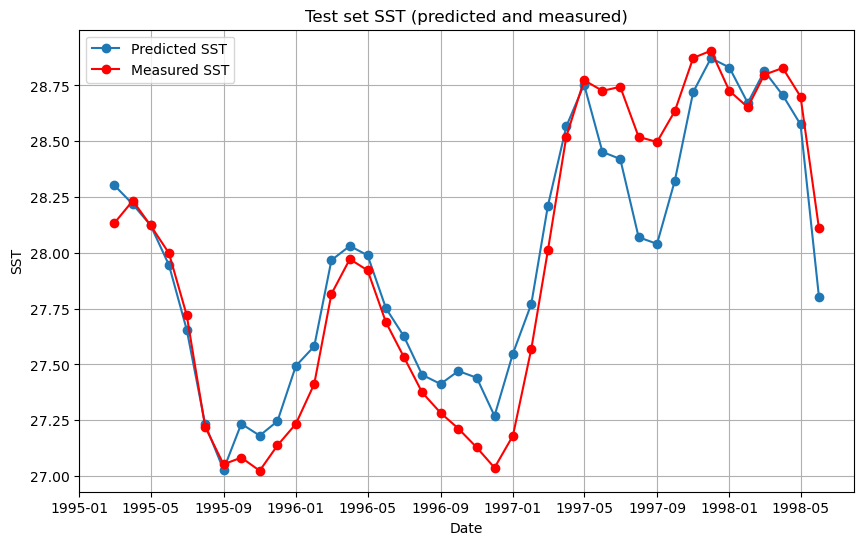

In [26]:
# Plot SST with increasing time
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], y_test_predicted, marker='o', linestyle='-', label='Predicted SST')
plt.plot(test_data['Date'], y_test, 'r', marker='o', linestyle='-', label='Measured SST')
plt.title('Test set SST (predicted and measured)')
plt.xlabel('Date')
plt.ylabel('SST')
plt.grid(True)
plt.legend()
plt.show()

#### 4.4 Lasso regression model

Now, I will try Lasso regression. Lasso regression performs feature selection by imposing a penalty on the absolute size of the regression coefficients, effectively selecting a subset of the most important features while shrinking the coefficients of less important features towards zero. In the context of SST prediction, this can be beneficial for identifying the most relevant variables (e.g., Zonal Winds, Meridional Winds, Humidity, Air Temperature) that influence SST variations in the equatorial Pacific Ocean. Furthermore, Lasso regression helps prevent overfitting by penalizing large coefficients, which can lead to more robust models that generalize well to unseen data. 

For Lasso, I will be using all 6 predictores, including the Zonal Winds because Lasso will perform feature selection.

In [29]:
# Extracting predictors and target variable for training and test sets (exclude 'ZonWinds')
X_train = train_data[['ZonWinds', 'MerWinds', 'Humidity', 'AirTemp', 'Lat', 'Lon']]
y_train = train_data['SST']
time_train = train_data['Date']

X_test = test_data[['ZonWinds', 'MerWinds','Humidity', 'AirTemp','Lat', 'Lon']]
y_test = test_data['SST']
time_test = test_data['Date']


# Create and fit the Lasso regression model
lasso_model = Lasso(alpha=0.1)  # You can adjust the alpha parameter for regularization strength
lasso_model.fit(X_train, y_train)

# Make predictions on the training data
y_train_predicted_lasso = lasso_model.predict(X_train)

# Evaluate the model on the training data
mse_train_lasso = mean_squared_error(y_train, y_train_predicted_lasso)
r2_train_lasso = r2_score(y_train, y_train_predicted_lasso)

print("Train Mean Squared Error (Lasso):", mse_train_lasso)
print("Train R-squared Score (Lasso):", r2_train_lasso)

# Make predictions on the test data
y_test_predicted_lasso = lasso_model.predict(X_test)

# Evaluate the model on the test data
mse_test_lasso = mean_squared_error(y_test, y_test_predicted_lasso)
r2_test_lasso = r2_score(y_test, y_test_predicted_lasso)

print("Test Mean Squared Error (Lasso):", mse_test_lasso)
print("Test R-squared Score (Lasso):", r2_test_lasso)


Train Mean Squared Error (Lasso): 0.1379098807228558
Train R-squared Score (Lasso): 0.9556557230388377
Test Mean Squared Error (Lasso): 0.042700651671096046
Test R-squared Score (Lasso): 0.8977589976371946


Based on the results above, Lasso regression model has good predictive performance on both datasets. The low mean squared error and high R-squared score on the test set suggest that the model generalizes well to unseen data, indicating its effectiveness in predicting SST based on the 'ZonWinds', 'MerWinds', 'Humidity', 'AirTemp', 'Lat', and 'Lon'.

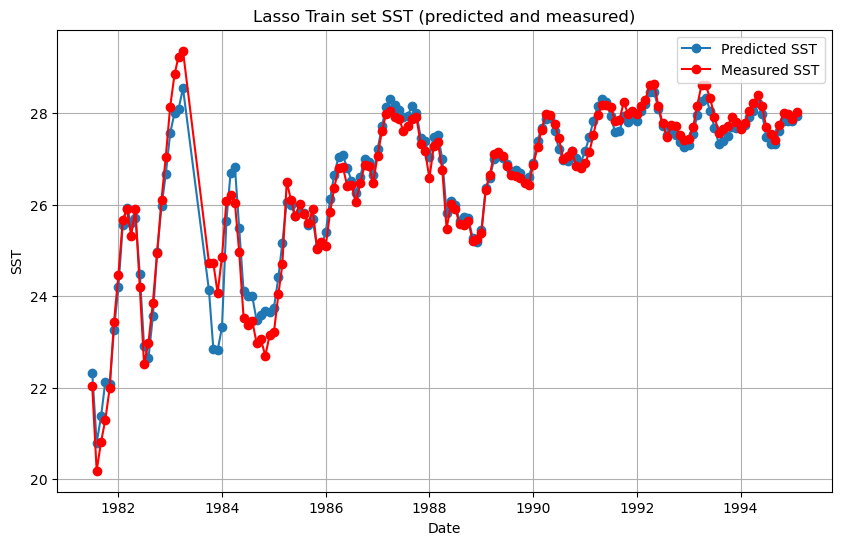

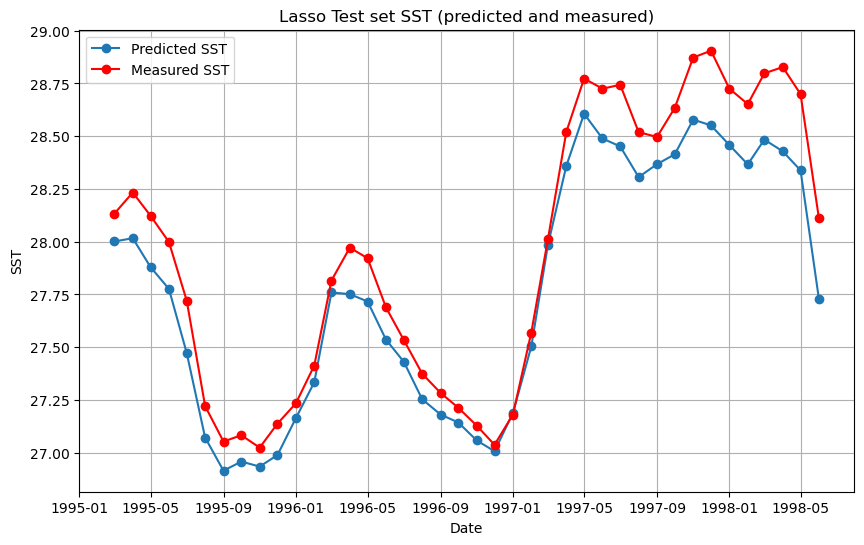

In [30]:
# Plot SST with increasing time
plt.figure(figsize=(10, 6))
plt.plot(train_data['Date'], y_train_predicted_lasso, marker='o', linestyle='-', label='Predicted SST')
plt.plot(train_data['Date'], y_train, 'r', marker='o', linestyle='-', label='Measured SST')
plt.title('Lasso Train set SST (predicted and measured)')
plt.xlabel('Date')
plt.ylabel('SST')
plt.grid(True)
plt.legend()
plt.show()

# Plot SST with increasing time
plt.figure(figsize=(10, 6))
plt.plot(test_data['Date'], y_test_predicted_lasso, marker='o', linestyle='-', label='Predicted SST')
plt.plot(test_data['Date'], y_test, 'r', marker='o', linestyle='-', label='Measured SST')
plt.title('Lasso Test set SST (predicted and measured)')
plt.xlabel('Date')
plt.ylabel('SST')
plt.grid(True)
plt.legend()
plt.show()

Comparing all 3 models presented above, it is possible to conlcude that based on the MSE, the simplest linear model performs the best.

#### 4.4 Lomb-Scargle Periodogram
Performing Lomb-Scargle periodogram analysis on El Niño data can provide valuable insights into the periodic patterns and frequencies present in the sea surface temperature (SST) measurements over time. 

El Niño events are characterized by periodic variations in SST in the equatorial Pacific Ocean. Lomb-Scargle periodogram analysis helps in identifying periodic signals within the SST data, allowing us to uncover underlying patterns and rhythms associated with El Niño. By analyzing the power spectrum obtained from Lomb-Scargle periodogram analysis, we can determine the dominant frequencies or periodicities present in the SST data. This information is crucial for understanding the temporal dynamics of El Niño events, such as their recurrence intervals and temporal evolution.

In [31]:
project_path = os.path.abspath("Final Project.ipynb")
elninodata = pd.read_csv(os.path.join(os.path.dirname(project_path), "datasets/elninodatacsv.csv"), na_values='.')
# Select columns to include in averaging
columns_to_average = ['Year', 'Month', 'Lat', 'Lon', 'ZonWinds', 'MerWinds', 'Humidity', 'AirTemp', 'SST']

# Group by 'Year' and 'Month' and calculate the mean of each variable
elninodata_month_avg = elninodata[columns_to_average].groupby(['Year', 'Month']).mean()

# Reset index to convert the grouped data back to a DataFrame
elninodata_month_avg = elninodata_month_avg.reset_index()


# Convert 'Year' and 'Month' columns to strings
elninodata_month_avg['Year'] = elninodata_month_avg['Year'].astype(str)
elninodata_month_avg['Month'] = elninodata_month_avg['Month'].astype(str)

# Combine 'Year' and 'Month' columns and convert to datetime
elninodata_month_avg['date'] = pd.to_datetime(elninodata_month_avg['Year'] + elninodata_month_avg['Month'], format='%y%m')

# Extract a single El Niño data series (SST)
sst_series = elninodata_month_avg['SST']
time = elninodata_month_avg['date']

In [32]:
# Code is adapted from the Lab 8 [14]
goodindexes = np.where(np.logical_not(np.isnan(sst_series)))
thrgood = time.iloc[goodindexes]

In [33]:
# Perform Lomb-Scargle Periodogram
# Generate frequency array
n = len(thrgood)
dt = 1 #month

In [34]:
frequencies = fft.rfftfreq(n, d=dt)
frequencies = frequencies[1:-1]

In [35]:
powers = signal.lombscargle(thrgood, sst_series.iloc[goodindexes], frequencies * 2.0 * np.pi, normalize=True)

In [36]:
# Define the frequency range to explore
min_period = 0.5  # in months
max_period = 216.0  # in months

# Convert periods to frequencies
min_freq = 1.0 / max_period
max_freq = 1.0 / min_period

# Filter the frequencies
mask = (frequencies >= min_freq) & (frequencies <= max_freq)
filtered_freq = frequencies[mask]
filtered_powers = powers[mask]

# Find the indices of the two tallest peaks
tallest_peak_indices = np.argsort(powers)[-2:] #in ascending order

# Get the corresponding frequencies
tallest_peak_freqs = frequencies[tallest_peak_indices]
tallest_peak_power = powers[tallest_peak_indices]

# Convert frequencies to periods
tallest_peak_periods = 1.0 / tallest_peak_freqs

print("Approximate periods associated with the 2 tallest peaks:")
for i, period in enumerate(tallest_peak_periods):
    print(f"Peak {i+1}: {period:.2f} months")
    

Approximate periods associated with the 2 tallest peaks:
Peak 1: 12.24 months
Peak 2: 7.70 months


The approximate periods associated with the two tallest peaks of El Niño SST, as calculated from the Lomb-Scargle periodogram analysis, provide insights into the periodicity of the phenomenon. 

Peak 1 (12.24 months): This period aligns well with the typical duration of El Niño events, which typically last around 9–12 months. The peak indicates a recurring pattern with a yearly cycle, suggesting that one of the dominant modes of variability in the SST data corresponds to the typical duration of El Niño events.

Peak 2 (7.70 months): While this period is shorter than the typical duration of El Niño events, it could represent a sub-annual variation or a different aspect of ENSO variability. It may capture shorter-term fluctuations within the ENSO cycle or be influenced by other climate phenomena.

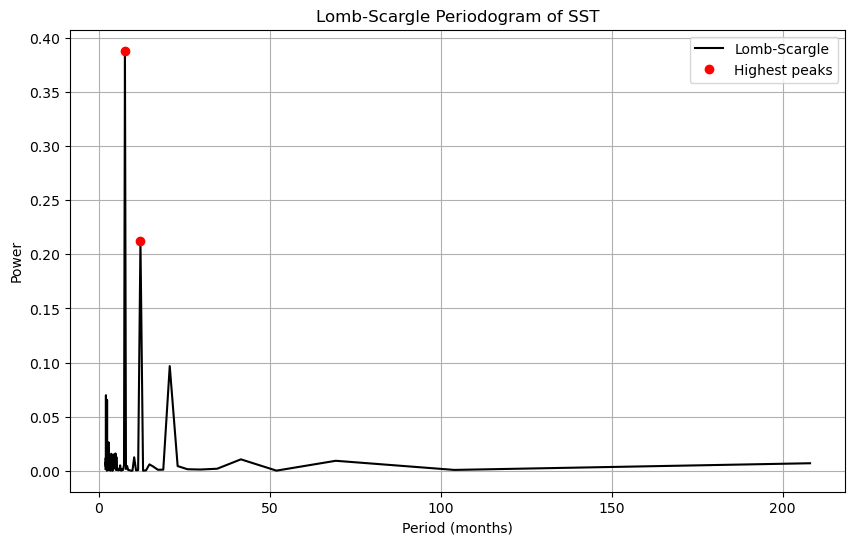

In [37]:
# Plot the Lomb-Scargle Periodogram
plt.figure(figsize=(10, 6))
#plt.semilogx(1.0 / filtered_freq, filtered_powers, marker='o', linestyle='-', color='b')
plt.plot(1/filtered_freq, filtered_powers, linestyle='-', color='k',label='Lomb-Scargle')
plt.plot(tallest_peak_periods, tallest_peak_power,'ro', label='Highest peaks')
plt.title('Lomb-Scargle Periodogram of SST')
plt.xlabel('Period (months)')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.show()

The peaks in the Lomb-Scargle Periodogram of SST data represent dominant cyclic patterns or frequencies present in the sea surface temperature (SST) data. The fact that the peaks occur at approximately 12.24 months and 7.7 months suggests that there are recurring patterns in SST fluctuations over these time scales [5].

In the context of SST data, in the case of El Niño events, which significantly influence SST patterns, recurring cycles on the order of months are common. Therefore, it's reasonable to interpret these peaks as indicative of such cyclic variations in SST.

### 5 References IEEE style


In [38]:
# Parse the BibTeX file
bib_data = parse_file('/home/demched7/references.bib')

# Counter for numbering
counter = 1

print("References:")
# Iterate through each entry and print formatted citation with numbers
for key in bib_data.entries.keys():
    entry = bib_data.entries[key]
    authors = ", ".join(str(person) for person in entry.persons["author"])
    title = entry.fields.get("title", "")
    journal = entry.fields.get("journal", "")
    volume = entry.fields.get("volume", "")
    number = entry.fields.get("number", "")
    pages = entry.fields.get("pages", "")
    year = entry.fields.get("year", "")
    link = entry.fields.get("link", "")

    citation = f"[{counter}] {authors} ({year}). \"{title}\""
    if journal:
        citation += f", {journal}"
    if volume:
        citation += f", {volume}"
    if number:
        citation += f"({number})"
    if pages:
        citation += f", {pages}"
    citation += "."
    if link:
        citation += f" Link: {link}"
    
    print(citation)
    print() 
    counter += 1

References:
[1] UCI Machine Learning Repository (1999). "El Nino". Link: https://doi.org/10.24432/C5WG62

[2] McPhaden, M. J., et al. (1998). "The Tropical Atmosphere Ocean (TAO) array: Past, present, and future", Bulletin of the American Meteorological Society, 79(11), 2181-2196. Link: https://tao.ndbc.noaa.gov/proj_overview/pubs/overview_ndbc.shtml

[3] N US Department of Commerce (2015). "Discussion on Humidity", National Weather Service. Link: https://www.weather.gov/lmk/humidity#:~:text=Warm%20air%20can%20possess%20more,if%20the%20air%20is%20warmer.

[4] Carlowicz, M. (2017). "El Niño: Pacific Wind and current changes bring warm, Wild weather", NASA Earth Observatory. Link: https://earthobservatory.nasa.gov/features/ElNino#:~:text(Image%20courtesy%20of%20the%20NASA,blowing%20over%20the%20vast%20Pacific.

[5] NOAA (2023). "What are El Niño and La Niña?", Ocean Facts. Link: https://oceanservice.noaa.gov/facts/ninonina.html#:~:text=El%20Ni%C3%B1o%20and%20La%20Ni%C3%B1a%20can%20both%2